In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%autosave 300

Autosaving every 300 seconds


In [7]:
!unzip  '/content/drive/MyDrive/data-Splitted'

Streaming output truncated to the last 5000 lines.
  inflating: data-Splitted/train/5/image_05203.jpg  
  inflating: data-Splitted/train/5/image_05204.jpg  
  inflating: data-Splitted/train/5/image_05205.jpg  
  inflating: data-Splitted/train/5/image_05206.jpg  
  inflating: data-Splitted/train/5/image_05207.jpg  
  inflating: data-Splitted/train/5/image_05208.jpg  
  inflating: data-Splitted/train/5/image_05209.jpg  
  inflating: data-Splitted/train/5/image_05211.jpg  
   creating: data-Splitted/train/50/
  inflating: data-Splitted/train/50/image_06297.jpg  
  inflating: data-Splitted/train/50/image_06298.jpg  
  inflating: data-Splitted/train/50/image_06299.jpg  
  inflating: data-Splitted/train/50/image_06300.jpg  
  inflating: data-Splitted/train/50/image_06301.jpg  
  inflating: data-Splitted/train/50/image_06302.jpg  
  inflating: data-Splitted/train/50/image_06303.jpg  
  inflating: data-Splitted/train/50/image_06304.jpg  
  inflating: data-Splitted/train/50/image_06306.jpg  
  

# import libraries

In [8]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json
from collections import Counter,OrderedDict
import cv2
import torch.nn.functional as F
from torchsummary import summary
from PIL import Image


## Transform the Dataset

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])])
}


# create dataloaders

In [10]:
data_dir = '/content/data-Splitted'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

dirs = {'train': train_dir,
        'valid': valid_dir,
        'test' : test_dir}

image_datasets = {x: datasets.ImageFolder(dirs[x], transform=data_transforms[x])
                  for x in ['train', 'valid', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True)
               for x in ['train', 'valid', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

## count no of sampels for each class

In [11]:
train_classes = [label for _, label in image_datasets['train']]
count=Counter(train_classes)
count

Counter({0: 32,
         1: 36,
         2: 39,
         3: 46,
         4: 38,
         5: 69,
         6: 69,
         7: 39,
         8: 38,
         9: 39,
         10: 32,
         11: 68,
         12: 65,
         13: 39,
         14: 48,
         15: 44,
         16: 32,
         17: 47,
         18: 72,
         19: 33,
         20: 32,
         21: 32,
         22: 32,
         23: 52,
         24: 62,
         25: 32,
         26: 68,
         27: 41,
         28: 36,
         29: 36,
         30: 32,
         31: 34,
         32: 60,
         33: 86,
         34: 44,
         35: 32,
         36: 44,
         37: 53,
         38: 101,
         39: 47,
         40: 104,
         41: 74,
         42: 32,
         43: 156,
         44: 53,
         45: 56,
         46: 39,
         47: 52,
         48: 73,
         49: 206,
         50: 68,
         51: 74,
         52: 48,
         53: 56,
         54: 87,
         55: 53,
         56: 91,
         57: 53,
         58: 36,
   

## plot no of samples for each class

<BarContainer object of 102 artists>

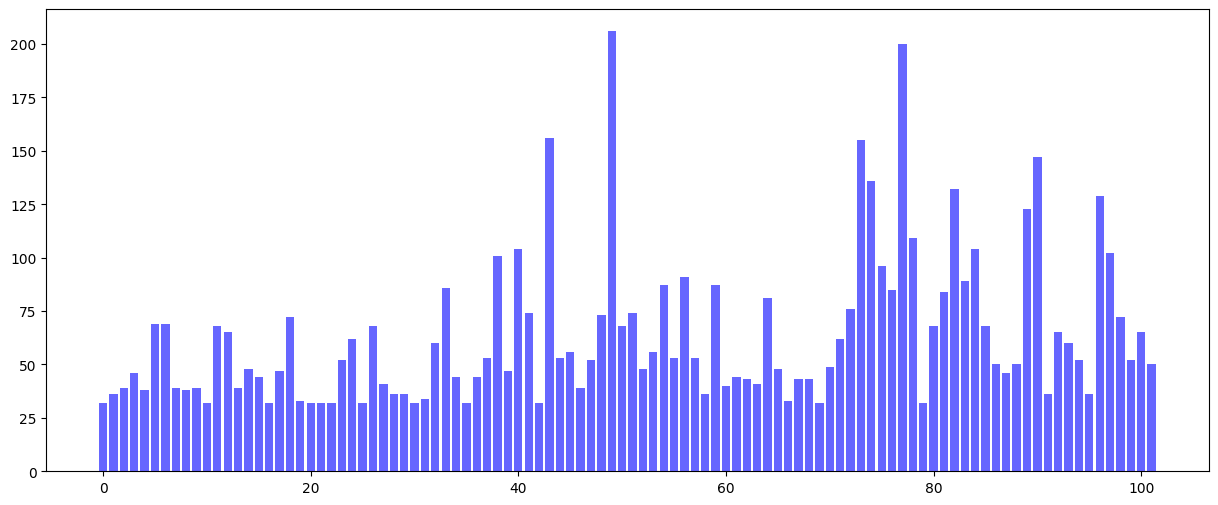

In [12]:
plt.figure(figsize=(15,6))
plt.bar(count.keys(), count.values(),color='b',alpha=.6)


In [13]:
x,y=next(iter(dataloaders['train']))
print(x.shape,y.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


## display some images of dataset

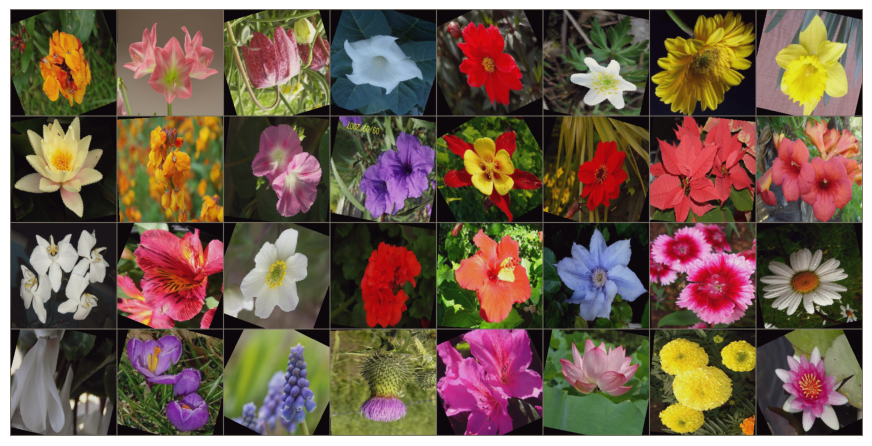

In [14]:
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(11, 11))
    plt.imshow(image)
    ax.axis('off')

    # Make a grid from batch
images, _ = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(images, nrow=8)
imshow(out)



## create model

In [15]:
class FFClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 4096)
        self.fc2 = nn.Linear(4096, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Transfer Learning (ResNet50)



In [17]:

model_conv = models.resnet50(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = FFClassifier(num_ftrs, 102)

model_conv = model_conv.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 329MB/s]


## train function

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('==> {} Loss: {:.4f} Accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## train the model

In [21]:

# Criteria NLLLoss which is recommended with Softmax final layer
criteria = nn.NLLLoss()

# # Observe that all parameters are being optimized
optimizer = optim.Adam(model_conv.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 4 epochs
sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)


# Number of epochs
eps=40
model_ft = train_model(model_conv, criteria, optimizer, sched, eps, device)

Epoch 0/39
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


==> train Loss: 2.7719 Accuracy: 0.3728
==> valid Loss: 1.3700 Accuracy: 0.6245

Epoch 1/39
----------
==> train Loss: 1.0500 Accuracy: 0.7149
==> valid Loss: 0.7886 Accuracy: 0.7845

Epoch 2/39
----------
==> train Loss: 0.7444 Accuracy: 0.7821
==> valid Loss: 0.7265 Accuracy: 0.7884

Epoch 3/39
----------
==> train Loss: 0.4642 Accuracy: 0.8677
==> valid Loss: 0.5670 Accuracy: 0.8426

Epoch 4/39
----------
==> train Loss: 0.4215 Accuracy: 0.8823
==> valid Loss: 0.5371 Accuracy: 0.8503

Epoch 5/39
----------
==> train Loss: 0.4078 Accuracy: 0.8872
==> valid Loss: 0.5486 Accuracy: 0.8452

Epoch 6/39
----------
==> train Loss: 0.3930 Accuracy: 0.8874
==> valid Loss: 0.5073 Accuracy: 0.8581

Epoch 7/39
----------
==> train Loss: 0.3793 Accuracy: 0.8937
==> valid Loss: 0.4974 Accuracy: 0.8606

Epoch 8/39
----------
==> train Loss: 0.3568 Accuracy: 0.9001
==> valid Loss: 0.4936 Accuracy: 0.8645

Epoch 9/39
----------
==> train Loss: 0.3769 Accuracy: 0.8957
==> valid Loss: 0.4979 Accuracy: 

## save model

In [22]:
model_conv.class_to_idx = image_datasets['train'].class_to_idx
model_conv.cpu()
torch.save({'arch': 'resnet50',
            'state_dict': model_conv.state_dict(),
            'class_to_idx': model_conv.class_to_idx},
            '/content/drive/MyDrive/classifier_V3.pth')

## load the model

In [23]:

def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)

    if chpt['arch'] == 'resnet50':
        model = models.resnet50(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False

        model.class_to_idx = chpt['class_to_idx']
        num_ftrs = model.fc.in_features
        model.fc = FFClassifier(num_ftrs, 102)
        model.load_state_dict(chpt['state_dict'])

        return model

model = load_model('/content/drive/MyDrive/classifier_V3.pth')


## summary of the model

In [24]:
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## calculate accuracy for some classes in test data

In [25]:
def calc_accuracy(model, data, cuda=True):

    model.eval()
    model.to(device)

    combined_predictions = []
    combined_true_labels = []
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()

            # obtain the outputs from the model
            outputs = model.forward(inputs)

            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)

            # check the
            if idx == 0:
                print("predicted class: ", predicted) #the predicted class
                print("predicted probability: ", torch.exp(_)) # the predicted probability

            predicted == labels.data

            combined_predictions = combined_predictions + list(predicted)
            combined_true_labels = combined_true_labels + list(labels.data)

    combined_predictions = [int(i) for i in combined_predictions]
    combined_true_labels = [int(i) for i in combined_true_labels]

    return combined_predictions, combined_true_labels

In [26]:
predictions, true_labels = calc_accuracy(model, 'test', True)


predicted class:  tensor([ 27,  21,  60,   4,  76,  42,  96,  49,   6,  77,  47,  81,  98,  75,
         74, 101,  22,  99,  57,  79,  60,  96,  11,  31,  85,  90,  87,  57,
          2,  47,  36,  41], device='cuda:0')
predicted probability:  tensor([0.8589, 0.9755, 0.9961, 0.9946, 0.9747, 0.3294, 0.9958, 0.9841, 0.9854,
        1.0000, 0.9888, 0.6229, 0.3292, 0.9971, 0.9962, 0.8106, 0.9593, 0.4916,
        0.9806, 0.9995, 0.9525, 0.6167, 0.7575, 0.9886, 0.9810, 0.6995, 0.5001,
        0.9941, 0.9574, 0.9899, 0.8433, 0.2832], device='cuda:0')


# total test accuracy

In [27]:
correct = 0
total = 0
with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders['test']):
            inputs, labels = inputs.cuda(), labels.cuda()
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 83 %


## process the test image as test transformer

In [28]:
def process_image(image):
    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

    ## Transforming image for use with network
    pil_tfd = transform(pil_im)

    # Converting to Numpy array
    array_im_tfd = np.array(pil_tfd)

    return array_im_tfd

# predict function for new data

In [29]:
def predict(image_path, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # Implement the code to predict the class from an image file
    np.set_printoptions(suppress=True)

    # Loading model - using .cpu() for working with CPUs
    loaded_model = model.cpu()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)

    # Calculating probabilities
    probs = torch.exp(output)
    probs_top = probs.topk(topk)[0]
    index_top = probs.topk(topk)[1]
    # Converting probabilities and outputs to lists
    probs_top_list = np.array(probs_top)[0]
    index_top_list = np.array(index_top[0])
    # Loading index and class mapping
    class_to_idx = loaded_model.class_to_idx
    # Inverting index-class dictionary
    indx_to_class = {x: y for y, x in class_to_idx.items()}

    # Converting index list to class list
    classes_top_list = []
    for index in index_top_list:
        classes_top_list += [indx_to_class[index]]

    return probs_top_list, classes_top_list


## Testing predict function

In [34]:
# Testing predict function

# Inputs are paths to saved model and test image
image_path = '/content/data-Splitted/test/50/image_06318'

probs,classes = predict(image_path, topk=5)
print(probs)
print(classes)

[0.5727503  0.29906648 0.08305091 0.02186267 0.01514926]
['50', '5', '12', '41', '54']


## load class name as strings not numbers

In [35]:
with open('/content/cat_to_name.json', 'r') as f:
    class_name = json.load(f)

## Show the result in test sample

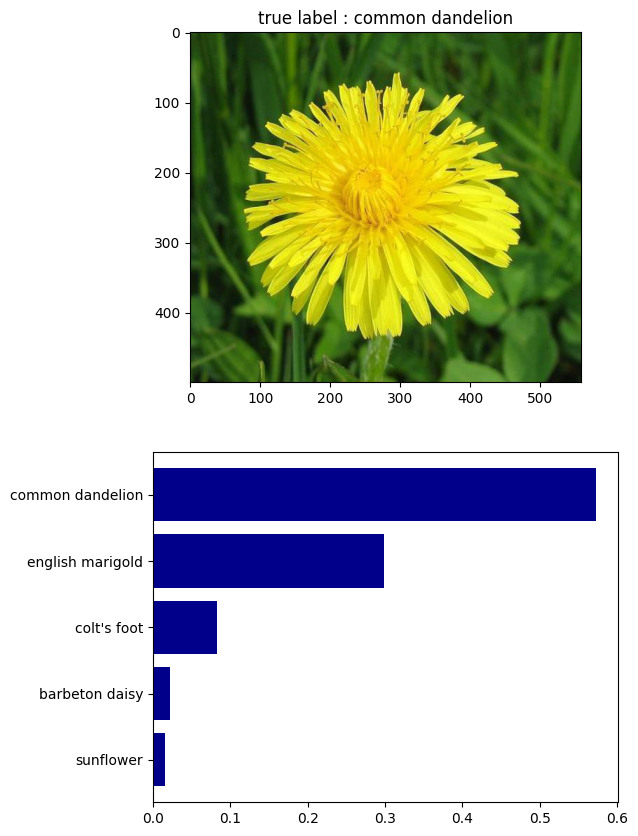

In [36]:
# Converting classes to names
names = []
for i in classes:
    names += [class_name[i]]

# Creating PIL image
image = Image.open(image_path+'.jpg')

# Plotting test image and predicted probabilites
f, ax = plt.subplots(2,figsize = (6,10))

ax[0].imshow(image)
ax[0].set_title("true label : "+names[0])

y_names = np.arange(len(names))
ax[1].barh(y_names, probs, color='darkblue')
ax[1].set_yticks(y_names)
ax[1].set_yticklabels(names)
ax[1].invert_yaxis()

plt.show()


# **Thanks 😊**
